# Test model for rigid body of colloid 

**Author:** HOOMD-blue, YeNguyenEdalgo

Simulation of colloid as a rigid body, addition of beads representing ligand on the surface of the colloid 

## Initialize

In [980]:
from __future__ import division
import hoomd
import hoomd.md

In [981]:
hoomd.context.initialize("");

In [982]:
par_ls            = 1
uc_length         = 15

colloid_diameter  = 10
A_diameter        = 1
B_diameter        = 1

A_pos             = (5.5, 0, 0)
A_pos_1           = (4.5, 0, 0)
A_pos_2           = (3.5, 0, 0)
#B_pos             = (0, 0, 5)

In [983]:
uc = hoomd.lattice.unitcell(N = 1, 
                            a1 = [uc_length, 0, 0],
                            a2 = [0, uc_length, 0],
                            a3 = [0, 0, uc_length], 
                            dimensions = 3,
                            type_name = ['colloid'],
                            diameter = [colloid_diameter])

system = hoomd.init.create_lattice(uc, n=par_ls)

notice(2): Group "all" created containing 1 particles


In [984]:
system.particles.types.add('A')
#system.particles.types.add('B')

rigid = hoomd.md.constrain.rigid();
rigid.set_param('colloid',
                types = 3*['A'],
                positions = [A_pos, A_pos_1, A_pos_2],
                diameters = 3*[A_diameter])

rigid.create_bodies()

snap = system.take_snapshot(all=True)

notice(2): constrain.rigid(): Creating 1 rigid bodies (adding 3 particles)


In [1035]:
snap = system.take_snapshot(all=True)

snap.bonds.resize(2)
snap.bonds.group[0] = [1, 2]
snap.bonds.group[1] = [2, 3]
snap.bonds.types = ['bondA', 'bondA_1']
snap.bonds.typeid[0] = 0
snap.bonds.typeid[1] = 1 

system.restore_snapshot(snap)

for i in range(0,snap.particles.N): 
    print(system.particles[i])

print(snap.bonds.typeid)

for j in range(0, snap.bonds.N):
    print(system.bonds[j])


tag         : 0
position    : (0.0, 0.0, 0.0)
image       : (0, 0, 0)
velocity    : (0.0, 0.0, 0.0)
acceleration: (0.0, 0.0, 0.0)
charge      : 0.0
mass        : 1.0
diameter    : 10.0
type        : colloid
typeid      : 0
body        : 0
orientation : (1.0, 0.0, 0.0, 0.0)
mom. inertia: (0.0, 0.0, 0.0)
angular_momentum: (0.0, 0.0, 0.0, 0.0)
net_force   : (0.0, 0.0, 0.0)
net_energy  : 0.0
net_torque  : (0.0, 0.0, 0.0)
net_virial  : (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

tag         : 1
position    : (5.5, 0.0, 0.0)
image       : (0, 0, 0)
velocity    : (0.0, 0.0, 0.0)
acceleration: (0.0, 0.0, 0.0)
charge      : 0.0
mass        : 1.0
diameter    : 1.0
type        : A
typeid      : 1
body        : 0
orientation : (1.0, 0.0, 0.0, 0.0)
mom. inertia: (0.0, 0.0, 0.0)
angular_momentum: (0.0, 0.0, 0.0, 0.0)
net_force   : (0.0, 0.0, 0.0)
net_energy  : 0.0
net_torque  : (0.0, 0.0, 0.0)
net_virial  : (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

tag         : 2
position    : (4.5, 0.0, 0.0)
image       : (0, 0, 0)
vel

In [1036]:
harmonicA = hoomd.md.bond.harmonic()
harmonicA.bond_coeff.set('bondA', k=1, r0=1)
harmonicA.bond_coeff.set('bondA_1', k=1, r0=1)

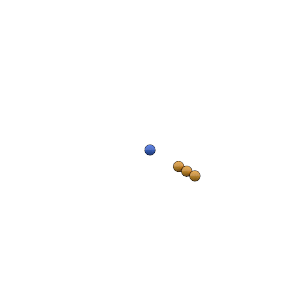

In [1037]:
import ex_render
ex_render.render_sphere_frame(system.take_snapshot())